 **<font size=5>Programming Assignment 8: Neural Networks with Tensorflow</font>**

## Problem Statement

In this programming assignment, you will write Tensorflow code to distinguish between a signal process which produces Higgs bosons and a background process which does not. We model this problem as a binary classification problem. 

Note: This assignment is not designed to make you a professional Tensorflow programmer, but rather to introduce you to, and make you practice, the basic constructs and functionalities of Tensorflow. 

### CPU vs GPU

You may want to read [this article](https://www.analyticsvidhya.com/blog/2017/05/gpus-necessary-for-deep-learning/) to know more about the CPU vs GPU discussion. This is totally optional, still highly recommended for those who are interested. 

When working locally, most of you would not have access to a [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit). However, once you have finished the assignment, you will submit your code on EdX, which will further be forwarded to a GPU instance running on AWS. Your code, when run on the GPU environment, should run much faster. 

However, you do not need to write any "GPU specific" code. Tensorflow automatically recognizes the underlying hardware, and optimizes your code to run accordingly.

The most common bottleneck to training faster with a GPU is usually the speed at which data is fed to the GPU for processing. So the input data pipeline is an important construct when writing efficient, scalable code to train Neural networks using Tensorflow.

### Dataset

For this assignment, we will use sampled data from a well known dataset: [Higgs Dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS). 

Some information regarding the data and the problem: 

This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not. The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes.

The train file has the following characteristics:

- Each row contains a comma-separated list of the names of the label and attributes
- Each row represents a single example
- The first column of each example is the label to be learned, and all other columns are attribute values.
- All attributes are numerical i.e. real numbers.

The test file has the following characteristics:

- Each row contains a comma-separated list of attributes
- Each row represents a single test example
- All attributes are numerical i.e. real numbers.

### Testing and Evaluation


For local testing and for two of the three submissions, you will use the small training and test datasets that have been provided along with this notebook. 

When submitting on EdX, your code will be trained and evaluated on a much larger sample of the full dataset. 

Some suggestions you should keep in mind while implementing the functions:

- Avoid doing repeated work i.e. anything that could be done outside the loop, should be outside.
- Read the markdown of this notebook carefully.

### Configuration File

To make your code more robust, and to aid the process of grading your work, most of the required parameters for the network training and testing will come from a [YAML](http://yaml.org/) config file named "nn_config.yaml". 

This file is present in the same directory as the notebook. We have added default values to parameters, but you may modify them for debugging purposes. 

Information regarding what these variables mean, and how you should use them is present as comments in the yaml file. Information regarding how to read variables from the YAML config file is mentioned later in this notebook.

However, remember that for grading your work we will use our own config files. So your code should always refer to variable values from the config file.

In [1]:
# Let's look at the contents of the YAML config file
!cat Data/nn_config.yaml 

## Training data file path
training_data_path: ./Data/higgs_train_small.csv

## Testing data file path
test_data_path: ./Data/higgs_test_small.csv 

## Location in which you will save the pickle file containing predictions on test data
output_predictions_pickle_path: ./Data/test_predictions.pkl

## Location in which the ground truth test labels are stored
gt_test_labels: ./Data/ground_truth_test_labels_small.pkl

## How to split the input training data into train and validation sets. Value of 0.8 means that if there were initially 100 training examples in the input data, you should split them such that the first 80 are used as training examples and last 20 should be used for validation.
training_to_validation_ratio: 0.8

## the learning rate you should use for your optimizer 
learning_rate: 0.05

## the total number of epochs or iterations to run over the (80) training examples
epochs: 200

## the number of mini batches in which you should split your (80) training examples. Continuing 

## Gameplan

You will write robust code that builds a feedforward neural network, and trains it according to the given set of parameters.

1. We will first load the training and test data using the parameters from the config file.
2. We will then split the training data into training and validation sets using the value of "training_to_validation_ratio" parameter in the config. 
    For example, if the param is 0.8, it means that the initial 80% of the data should be kept for training, while the rest 20% should be used for validation.
3. We will use [Cross Entropy Loss](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) as our loss function and minimize it using AdamOptimizer as our optimizer.
4. We will train our model in batches inside our main training loop. You will divide the training data into `num_batches` number of mini batches and for each epoch you will iterate and train over those many number of batches.
5. You can use "display_step" param to control the frequency of print statements.
6. You will maintain a list of training accuracies and losses (one value for each epoch).
7. You will maintain a list of validation accuracies and losses (one value for each epoch).

## Initialization 

In [2]:
## Tensorflow produces a lot of warnings. We generally want to suppress them. The below code does exactly that. 
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

## Pretty Print
import pprint as pp

In [4]:
import yaml
def import_config():
    with open("Data/nn_config.yaml", 'r') as ymlfile:
        try:
            cfg = yaml.load(ymlfile)
        except yaml.YAMLError as err:
            print(err)
    return cfg

In [5]:
## The below function tests if Tensorflow has access to GPU or not.
working_locally = True
def test_cpu_gpu():
    if tf.test.gpu_device_name():
        global working_locally
        working_locally    =False
        print('Default GPU Device detected: {}'.format(tf.test.gpu_device_name()))
        print('If you are using GPU on your computer while developing this assignment, \n\
              uncomment the next cell which sets working_locally = True.')
    else:
        print('''Your hardware either does not have a GPU or is not configured to use the GPU version of TF.
        However, you do not need a GPU for this assignment as you will be completing this assigment on a
        CPU enviroment, but evaluating it on a GPU enviroment.''')
        
test_cpu_gpu()

Your hardware either does not have a GPU or is not configured to use the GPU version of TF.
        However, you do not need a GPU for this assignment as you will be completing this assigment on a
        CPU enviroment, but evaluating it on a GPU enviroment.


<a id='the_destination'></a>

In [6]:
#Comment out this cell when submitting

#working_locally = True

#Comment out this cell when submitting

In [7]:
cfg = import_config()

## Is it loaded correctly?
pp.pprint(cfg)

{'dataset_size': 'small',
 'display_step': 5,
 'epochs': 200,
 'gt_test_labels': './Data/ground_truth_test_labels_small.pkl',
 'hidden_layer_sizes': {'first_layer': 20, 'second_layer': 8},
 'learning_rate': 0.05,
 'num_mini_batches': 10,
 'output_predictions_pickle_path': './Data/test_predictions.pkl',
 'test_data_path': './Data/higgs_test_small.csv',
 'training_data_path': './Data/higgs_train_small.csv',
 'training_to_validation_ratio': 0.8}


## Reading in Data 

In [8]:
## Reading file paths from the config dictionary
train_file_name = cfg['training_data_path']
test_file_name = cfg['test_data_path']

In [9]:
## Loading the Data
training_data = np.loadtxt(train_file_name, delimiter = ',')
test_data = np.loadtxt(test_file_name, delimiter = ',')

Now we have loaded the training and test data. However, we cannot use it directly. We first need to standardize it.

### Exercise: Implement the Standardize Function 

Neural networks work best when all features roughly are on the same scale and are centered around the mean.

This is done by standardizing the feature vectors. Feature standardization makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance.

The function <font color="blue">standardize</font> takes the input data and determines the distribution mean and standard deviation for each feature. Next the mean is subtracted from each feature. Then the mean-subtracted values of each feature are divided by its standard deviation.

**<font color="magenta" size=2>Example Input</font>**
There are 3 training examples with 4 features each 
``` python
np.array([[-0.22 -0.19 -0.17 -0.13][-0.1 -0.05 0.02 0.10][0.03 0.11 0.12 0.15]])
```

**<font color="blue" size=2>Example Output</font>**
There are 3 training examples (which have been standardized) along each of the 4 features
``` python
array([[-1.51388369, -1.27795377, -1.12066715, -0.80609391],
       [-0.57016399, -0.17694744,  0.37355572,  1.00270219],
       [ 0.45219903,  1.08134549,  1.1599888 ,  1.39591873]])
```

Refer the "Standardization" section of this [Wikipedia Feature Scaling Article](https://en.wikipedia.org/wiki/Feature_scaling).

In [10]:
def standardize(data):
    
    # YOUR CODE HERE
    return np.sum([data, -np.mean(data, axis=0)], axis=0)/np.std(data, axis=0)#np.transpose([[(d - np.mean(data[:,col])) / np.std(data[:,col]) for d in data[:,col]] for col in range(data.shape[1])])
#np.transpose([[(d - np.mean(data)) / np.std(data) for d in data] for data in np.transpose(data)])
        

In [11]:
dummy = np.array([[-0.22, -0.19, -0.17, -0.13],[-0.1, -0.05, 0.02, 0.10],[0.03, 0.11, 0.12, 0.15]])
assert standardize(dummy).__class__ == np.ndarray, "should return numpy array"
assert standardize(dummy).shape == dummy.shape , "should have the same shape as the input array"

dummy_ans = np.round(np.array([[-1.20809282, -1.19664225, -1.33025759, -1.39425471],
       [-0.03265116, -0.05439283,  0.2494233 ,  0.4920899 ],
       [ 1.24074398,  1.25103507,  1.08083429,  0.90216481]]),3)
assert (np.round(standardize(dummy),3) == dummy_ans).all(), 'Check your return values. Are you standardizing the data correctly?'
del dummy, dummy_ans

In [12]:
# Hidden Tests Here

### Exercise: Implement the parse_training_data function

The function <font color="blue">parse_training_data</font> takes the input data and returns labels and features. 

Remember that the first column of the training data is the labels, and the remaining columns are the features

The labels should be reshaped to a 2-D numpy matrix of shape (dataset_size, 1)
The features should be standardized and have be a 2-D numpy matrix of shape (dataset_size, 28)

**<font color="magenta" size=2>Example Input</font>**
There are 3 training examples with the label and 3 features each 
``` python
np.array([[1 -0.19 -0.17 -0.13][0 -0.05 0.02 0.10][0 0.11 0.12 0.15]])
```

**<font color="blue" size=2>Example Output</font>**
Returns a tuple:
    1st element is the labels
    2nd element is the standardized features
``` python
(array([[1.],
        [0.],
        [0.]]), array([[-1.19664225, -1.33025759, -1.39425471],
        [-0.05439283,  0.2494233 ,  0.4920899 ],
        [ 1.25103507,  1.08083429,  0.90216481]]))
```


Remember to use the standardize function appropriately inside this function and use the visible assert statements to finetune the shape of your returned data.

In [13]:
def parse_training_data(numpy_matrix):
    
    # YOUR CODE HERE
    labels = numpy_matrix[:,0].reshape(numpy_matrix.shape[0], 1)#np.array([[row[0]] for row in numpy_matrix])
    features = standardize(numpy_matrix[0:, 1:,])
    
    return labels, features

In [14]:
# Parse Training Data. You will later split the `labels` and `features` into training and validation sets.
labels, features = parse_training_data(training_data)

In [15]:
assert labels.shape[1] == 1, "labels should have just 1 column"
assert features.shape[1] == 28, "features should have 28 columns"

In [16]:
#Hidden tests here

### Exercise: Implement the parse_test_data function

The function <font color="blue">parse_test_data</font> takes the input data and returns labels and features. 

We do not have access to labels while predicting the classes that our test examples belong to. The input data files for the test data would not have the labels column. 

So we need a different function to parse the test data. This should only return standardized features.

The features should be standardized and have be a 2-D numpy matrix of shape (dataset_size, 28)

**<font color="magenta" size=2>Example Input</font>**
There are 3 training examples with the label and 3 features each 
``` python
np.array([[-0.19 -0.17 -0.13][-0.05 0.02 0.10][0.11 0.12 0.15]])
```

**<font color="blue" size=2>Example Output</font>**
Returns a tuple:
    1st element is the labels
    2nd element is the standardized features
``` python
array([[-1.19664225, -1.33025759, -1.39425471],
       [-0.05439283,  0.2494233 ,  0.4920899 ],
       [ 1.25103507,  1.08083429,  0.90216481]])
```


Remember to use the standardize function appropriately inside this function.

In [17]:
def parse_test_data(numpy_matrix):
    
    # YOUR CODE HERE
    test_features = standardize(numpy_matrix)
    
    return test_features

In [18]:
test_features = parse_test_data(test_data)

## Building the Neural Network 

### Initializing important parameters
Use the below params appropriately inside the train_nn() function. We have initialized these variables in order to assist you in your implementation.

In [19]:
learning_rate = cfg['learning_rate']
training_epochs = cfg['epochs']
train_valid_split = cfg['training_to_validation_ratio']
num_batches = cfg['num_mini_batches']
display_step = cfg['display_step']

num_examples= training_data.shape[0]

# The first `num_train_examples` should be used for training, the rest for validation.
num_train_examples = int(num_examples * train_valid_split)

batch_size = num_train_examples/num_batches


# Network Parameters
n_hidden_1 = cfg['hidden_layer_sizes']['first_layer'] # 1st layer number of features
n_hidden_2 = cfg['hidden_layer_sizes']['second_layer'] # 2nd layer number of features
n_input = 28 
n_classes = 1 


print("Total Training examples: %d, Number of Batches: %d, Batch Size: %d" %(num_train_examples,num_batches,batch_size))

Total Training examples: 8000, Number of Batches: 10, Batch Size: 800


### Initializing placeholders for feeding into the TF graph

Define the TF placeholders which will receive data for each mini batch. Similarly define weights and biases as TF variables 

In [20]:
# TF Graph input
## Use the below placeholders appropriately inside the train_nn() function

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, 1])


# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

### Exercise: Implement the `calc_num_total_learnable_params` function.

This function  calculates the number of learnable parameters of the network model. This number directly relates to the complexity of your model, as well as the training time. 

The function <font color="blue">calc_num_total_learnable_params</font> takes the weights dictionary and bias dictionary and returns an integer which is equal to the number of total parameters in the network. 

You can make use of the `get_dims_as_tuple` as a helper function to access the shape of the weight and bias matrices easily.

In [21]:
# Helper function which you may use in implementing `calc_num_total_learnable_params(weights,biases)` function below.
def get_dims_as_tuple(x):
    shape = x.get_shape()
    dims = []
    for dim in shape:
        dims.append(dim.value)
    return tuple(dims)

# example usage:
get_dims_as_tuple(weights['h1'])

(28, 20)

In [22]:
def calc_num_total_learnable_params(weights,biases):
    
    # YOUR CODE HERE
    weights_num_params = sum([get_dims_as_tuple(v)[0]*get_dims_as_tuple(v)[1] for v in weights.values()])
    biases_num_params = sum([get_dims_as_tuple(v)[0] for v in biases.values()])
    
    return weights_num_params + biases_num_params

In [23]:
assert calc_num_total_learnable_params(weights, biases) == 757, "The total number of learnable parameters have been calculated incorrectly."

### Exercise: Create FeedForward Network Model

This function needs to be filled up with code to construct the remaining two layers of the neural network. You have to add one more hidden layers and also the output layer.

You should use the sigmoid activation function. Tensorflow's `tf.nn.sigmoid()` function should be helpful. 

We have partially implemented this function. Complete the rest of it. Remember to not apply the sigmoid activation at the last layer as we will be using `tf.nn.sigmoid_cross_entropy_with_logits()` later which does that.


In [24]:
def create_feedforward_nn_model(x, weights, biases):
    # Hidden layer with SIGMOID activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # YOUR CODE HERE
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    
    out_layer = tf. add(tf.matmul(layer_2, weights['out']), biases['out'])
    
    return out_layer

### Exercise: Stitch the Neural Network Model

Using the appropriate Tensorflow libraries, implement each of the following operations:
- loss as the CrossEntropyLoss
- train_op as the AdamOptimizer that minimizes the loss

As inputs to these operators, you can use:
- `pred_raw` which is the output of your neural network's last layer
- `pred` is the predicted label, which is the output of rounding `pred_raw`. 

You might want to look at the Tensorflow Section notebooks as well as the TensorFlow API.

Two of the returned values have been implemented as a hint for you.

Functions that could be useful here: 

```python
tf.nn.sigmoid_cross_entropy_with_logits()
tf.reduce_mean()
tf.round()
tf.sigmoid()
tf.train.AdamOptimizer().minimize()
```

In [25]:
# Construct model
def stitch_network(x, y, weights, biases, learning_rate):
    
    pred_raw = create_feedforward_nn_model(x, weights, biases)
    pred = tf.cast(tf.round(tf.nn.sigmoid(pred_raw)), tf.float64)
    
    # YOUR CODE HERE
    loss = tf.cast(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred_raw, labels=y)), tf.float64)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return pred_raw, pred, loss, train_op


pred_raw, pred, loss, train_op = stitch_network(x, y, weights, biases, learning_rate)

In [26]:
assert loss.__class__ == tf.Tensor
assert loss.get_shape() == (), "Make sure you have used reduce_mean"

In [27]:
# Initializing the variables - IMPORTANT
init = tf.global_variables_initializer()

## Training and Testing the Neural Network

### Exercise: Writing the Train function

This is where you will train your network.

Your goal is to complete the following function named `train_nn()`. 

To help you structure your implementation, we have provided some starter code. 

We have also detailed each of the steps you need to pay attention to inside the main training loop.

Remember you have access to all the parameters we initialized early on in the notebook, as well as to the parameters defined in the config file. 

`train_nn()` should return 5 python lists
1. training_losses
2. validation_losses
3. training_accs
4. validation_accs
5. test_predictions 

In [28]:
def train_nn():
#     pred_raw = create_feedforward_nn_model(x, weights, biases)
    
#     with tf.name_scope('Loss'):
#         loss_op = tf.cast(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred_raw, labels=y)), tf.float64)

#     with tf.name_scope('SGD'):
#         optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#         train_op = optimizer.minimize(loss_op)

#     with tf.name_scope('Prediction'):
#         prediction = tf.round(tf.nn.sigmoid(pred_raw))

#         #Check accuracy of prediction
#     with tf.name_scope('Accuracy'):
#         #prediction = tf.round(tf.nn.sigmoid(pred_raw))
#         correct_pred = tf.equal(prediction, y)
#         accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float64))
    
#     with tf.name_scope('Test_Prediction'):
#         prediction = tf.round(tf.nn.sigmoid(pred_raw))
#         test_prediction = tf.cast(prediction, tf.float64)
            
#     init = tf.global_variables_initializer()
    with tf.Session() as sess:
        
        #logits = create_feedforward_nn_model(x, weights, biases)
        
        sess.run(init)
        
        ## this is needed to print debug statements during training.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        x_train, x_valid = features[:num_train_examples], features[num_train_examples:]
        y_train, y_valid = labels[:num_train_examples], labels[num_train_examples:]

        training_losses = []
        training_accs = []

        validation_losses = []
        validation_accs = []

        batch_size_round = round(batch_size)
        
        for epoch in range(training_epochs):
        
            '''
            We recommend you first think about how you will implement 
                this on your own before proceeding to read any further.
        
            HINT: You should implement the following procedure here:
        
            An epoch is one pass through your training data
            1. Keep a counter of this epoch's total loss. 
               You will need this to average over the batches.
            2. Keep a counter of the number of correct predictions in your epoch. 
               You will need this to sum over the batches to calculate per epoch accuracy.
            
            -- For each batch --  (you should have `num_batches` number of batches totally)
                3. subset your features and labels from x_train and y_train
                ex. for batch 1, you'd select all examples in the interval [0,batch_size)
                    for batch 2, it would be between [batch_size, 2*batch_size)
                    Make sure to account for a possible fractional batch as your last batch
                4. Massage your x_batch and y_batch into numpy arrays of shape (size_of_batch, 28) 
                    and (size_of_batch, 1) respectively
                    
                5. Feed the x_batch and y_batch into your tensorflow graph 
                    and execute the optimizer, loss, and pred 
                    in order to train your model using the current batch 
                    and also get back the loss for the batch and predictions for the batch.
                    The contribution of each batch's loss towards the epoch's loss will be (batch's loss)*(number of examples in batch)/(total training examples)
                6. Count the number of correct predictions for this batch and add it to the counter for the 
                    correct predictions in the epoch
                    
            7. Append the average epoch loss to `training_losses`
            8. Calculate your epochs's accuracy as the total number of correct predictions in your epoch
                    divided by the number of training examples
            9. Append the epoch's accuracy to `training_accs`
            
            --Validation at end of every epoch--
            
            10. Massage your validation labels (y_valid) into a numpy arrays of shape (validation_set_size, 1)
            11. With y_valid and x_valid as input to your graph,
                    calculate the validation loss and validation predictions
            12. Calculate the number of correct validation predictions by comparing against your validation labels
            13. Append validation loss and validation accuracy to their respective lists
            14. NOTE: Avoid printing a lot of debug information when you submit the assignment. 
                This reduces the speed of execution.
                If you want to print some information every so often, you can use the following line 
                at the end of your epoch loop:
                if epoch%display_step==0:
                    print("Epoch %d | Tr loss: %f | Tr accuracy %f | Va loss: %f | Va accuracy: 
                        %f"%(epoch + 1,<average training loss of epoch>,
                            <training accuracy of this epoch>, 
                            <validation loss of this epoch>, <validation accuracy of this epoch>))
            '''
            # YOUR CODE HERE
            epoch_loss = 0#[]
            epoch_correct_pred = 0#[]
            
            for batch in range(num_batches + 1):
                if (batch == num_batches) and (batch_size_round * num_batches < num_train_examples):
                    x_batch = np.array(x_train[batch * num_batches:])
                    y_batch = np.array(y_train[batch * num_batches:])
                else:
                    x_batch = np.array(x_train[batch * batch_size_round:(batch + 1) * batch_size_round])
                    y_batch = np.array(y_train[batch * batch_size_round:(batch + 1) * batch_size_round])
                
                #sess.run(train_op, feed_dict={x: x_batch, y: y_batch})
                #batch_pred, batch_loss = sess.run([pred, loss], feed_dict={x: x_batch, y: y_batch})
                batch_pred_raw, batch_pred, batch_loss, batch_train = sess.run([pred_raw, pred, loss, train_op], feed_dict={x: x_batch, y: y_batch})
                epoch_loss = np.nansum([epoch_loss, batch_loss * batch_size_round / num_train_examples])#.append(loss) #* len(x_batch) / num_train_examples
                epoch_correct_pred += np.sum(batch_pred == y_batch)#tf.reduce_sum(tf.cast(tf.equal(batch_pred, y_batch), tf.float64))#.append(acc) #correctPred
            
            training_losses.append(epoch_loss)#np.nanmean(epoch_loss))
            training_accs.append(epoch_correct_pred / num_train_examples)#np.nanmean(epoch_acc))
            
            valid_loss, valid_pred = sess.run([loss, pred], feed_dict={x: np.array(x_valid), y: np.array(y_valid)})
            validation_losses.append(valid_loss)
            validation_accs.append(np.sum(valid_pred == y_valid) / (num_examples - num_train_examples))#tf.reduce_sum(tf.cast(tf.equal(valid_pred, y_valid), tf.float64)) / (num_examples - num_train_examples))
            #if epoch%display_step==0:
                #print("Epoch %d | Tr loss: %f | Tr accuracy %f | Va loss: %f | Va accuracy: %f"%(epoch + 1,training_losses[-1],training_accs[-1],valid_loss, validation_accs[-1]))
            
        
        print("Optimization Finished!")

        test_predictions = []
        '''
        HINT: 
        Using the `test_features` as input to your trained graph,
            run the graph once more to calculate the predictions on the test set
        Cast the returned numpy array into the python list called `test_predictions`
            where each element has type np.float64 
        '''
        # YOUR CODE HERE
        test_predictions = np.hstack(sess.run(pred, feed_dict={x: test_features}))
        
        ## this is needed to print debug statements during training.
        coord.request_stop()
        coord.join(threads)
    
    ## close TF session if open
    if 'session' in locals() and sess is not None:
        print('Close interactive session')
        sess.close()
        
    return training_losses, validation_losses, training_accs, validation_accs, test_predictions

In [29]:
training_losses, validation_losses, training_accs, validation_accs, test_predictions = train_nn()

Optimization Finished!


In [30]:
## making sure your train_nn() function returns variables as expected
assert type(training_accs)==list,"incorrect return type"
assert type(validation_accs)==list, "incorrect return type"
assert type(training_losses)==list, "incorrect return type"
assert type(validation_losses)==list, "incorrect return type"
assert type(test_predictions[0])==type(training_accs[0])==type(validation_accs[0])==np.float64, "wrong return type"
assert type(training_losses[0])==type(validation_losses[0])==np.float64, "incorrect return type"
assert len(training_accs)==len(validation_accs)==len(training_losses)==len(validation_losses)==training_epochs,"incorrect returned lengths"
assert len(test_predictions)==len(test_features),"incorrect returned lengths"

### Analyzing loss and accuracy trends vs number of epochs

In [31]:
def plot_loss_vs_epochs(training_losses, validation_losses):
    plt.title("loss vs epochs")
    plt.plot(training_losses)
    plt.plot(validation_losses)
    plt.legend(["training","validation"])

In [32]:
def plot_acc_vs_epochs(training_acc, validation_acc):
    plt.title("accuracy vs epochs")
    plt.plot(training_acc)
    plt.plot(validation_acc)
    plt.legend(["training","validation"])

In [33]:

def plots(training_losses, validation_losses, training_accs, validation_accs):
    
    fig = plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    plot_loss_vs_epochs(training_losses, validation_losses)
    plt.subplot(1,2,2)
    plot_acc_vs_epochs(training_accs, validation_accs)

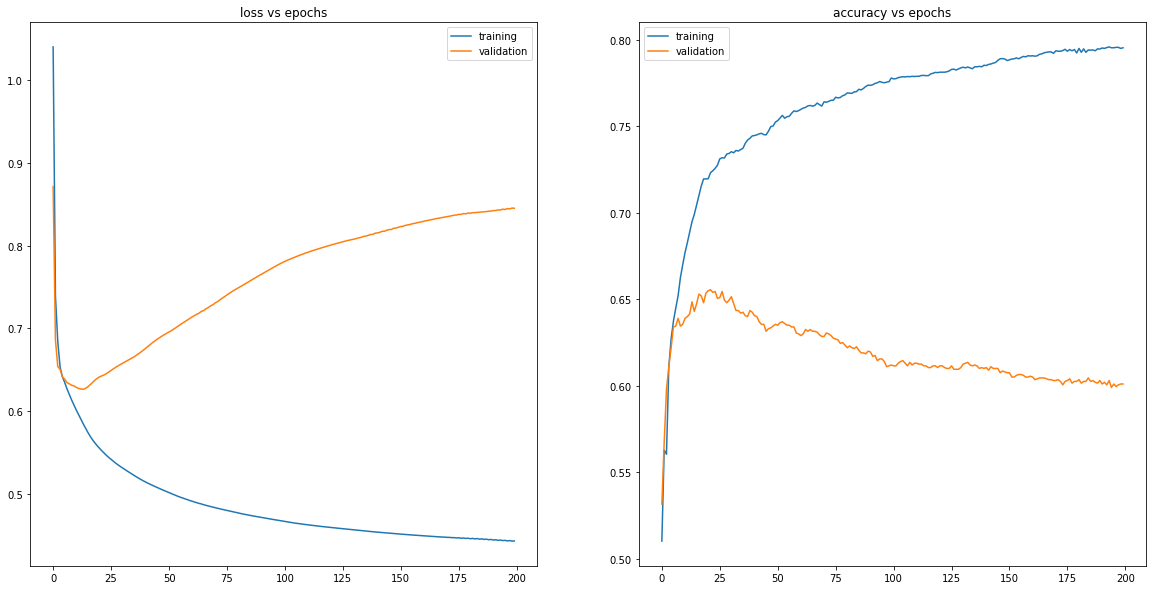

In [34]:
plots(training_losses, validation_losses, training_accs, validation_accs)

### Scoring Your Test Predictions

The following code saves your test predictions locally in the same directory.

It is required in order to give you a grade based on your network's performance.

In [35]:
import pickle
def save_test_predictions(test_predictions):
     with open(cfg['output_predictions_pickle_path'], 'wb') as f:
        pickle.dump(test_predictions, f)
save_test_predictions(test_predictions)

In [36]:
## calculating your model's accuracy on the test set
if working_locally:
    test_predictions_student = cfg['output_predictions_pickle_path']
    ground_truth_labels_test =  cfg['gt_test_labels']

    with open(test_predictions_student, 'rb') as f:
        test_labels = np.array(pickle.load(f))

    with open(ground_truth_labels_test, 'rb') as f:
        gt_labels = np.array(pickle.load(f))

    test_acc = (sum(gt_labels==test_labels)/len(gt_labels))*100
    print("Test Set Accuracy: "+str(test_acc))

    assert test_acc>60, "Your model does not perform sufficiently well on the test set."
else:
    assert True

Test Set Accuracy: 64.1


In [37]:
#Hidden tests here

In [38]:
#Hidden tests here

In [39]:
#Hidden tests here

In [40]:
#Hidden tests here

## Submission Instructions

Please refer to the submission instructions on EdX.

Remember to **comment out** [`working_locally = True`](#the_destination) cell before submitting for evaluation on the large dataset